In [1]:
import sys
import os
import numpy as np
import pandas as pd

sys.path.append(os.path.abspath('../..'))

from offshore_wind_nj.config import JERSEY_ATLANTIC_DATA_DIR, FIGURES_DIR
import matplotlib.pyplot as plt
from pyproj import Proj, Transformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler

2025-04-05 13:49:36.402 | INFO     | offshore_wind_nj.config:<module>:11 - PROJ_ROOT path is: /nfs/storage1/home/noriegac/Documents/Offshore_Wind_Research


In [2]:
jersy_atlantic_path = JERSEY_ATLANTIC_DATA_DIR / 'JAW_Wind_Data.xlsx'
df = pd.read_excel(jersy_atlantic_path)

In [3]:
df['u_vector'] = np.sin(np.radians(df['WindDirection'])) 
df['v_vector'] = np.cos(np.radians(df['WindDirection']))

In [4]:
df.fillna({'PowerkW':-10}, inplace=True)

In [5]:
df.loc[df[df['PowerkW']<=0].index, 'PowerkW'] = 0

In [6]:
# Identify timestamps where ALL turbines have missing WindSpeed data
timestamps_all_missing = df.groupby('StampTime')['WindSpeed'].apply(lambda x: x.isna().all())

# Get a list of these timestamps
timestamps_to_drop = timestamps_all_missing[timestamps_all_missing].index

# Drop rows with these timestamps
df = df[~df['StampTime'].isin(timestamps_to_drop)].reset_index(drop=True)


In [7]:
df[df['StampTime'].isin(timestamps_all_missing[timestamps_all_missing].index)]

,Turbine,StampTime,WindSpeed,WindDirection,PowerkW,u_vector,v_vector


In [8]:
for column in ['WindSpeed', 'u_vector', 'v_vector']:
    df[column] = df.groupby('StampTime')[column]\
                                    .transform(lambda x: x.fillna(x.mean()))

In [9]:
turbines = [
    {"Turbine": "T01", "latitude": 39.3839, "longitude": -74.4485},
    {"Turbine": "T02", "latitude": 39.3822, "longitude": -74.4504},
    {"Turbine": "T03", "latitude": 39.3801, "longitude": -74.4497},
    {"Turbine": "T04", "latitude": 39.3825, "longitude": -74.4454},
    {"Turbine": "T05", "latitude": 39.3811, "longitude": -74.4477}
]

turbines_df = pd.DataFrame(turbines)


In [10]:
df = pd.merge(df, turbines_df, on='Turbine', how='left')


# 🧠 Wind Turbine Power Prediction using Feedforward ANN

## 🎯 Goal

Develop a baseline **Artificial Neural Network (ANN)** model to predict the **power output (`PowerkW`)** of wind turbines using real-time wind features at **10-minute intervals**. This model serves as a benchmark to compare against more advanced spatial and temporal models (e.g., CNNs, ViTs, GNNs, CNN-GRU).

---

## 🧪 Scientific Motivation

Wind turbines respond non-linearly to environmental conditions. Modeling this response using data-driven techniques helps:
- Optimize energy production
- Predict performance under various wind scenarios
- Support smarter turbine layout and control strategies

ANNs provide a flexible, fast method to learn these patterns directly from data.

---

## 🧩 Input Features

Each sample (row) represents a single **turbine at a single 10-minute timestamp**.

- `WindSpeed`
- `u_vector` (east-west wind component)
- `v_vector` (north-south wind component)
- One-hot encoded turbine ID: `Turbine_T01`, ..., `Turbine_T05`

Total input dimension: 8 features per sample

---

## 🎯 Target

- `PowerkW`: Actual power output of the turbine at that time

---

## 📐 Methodology

### 1. Preprocessing
- Normalize all numerical inputs
- One-hot encode turbine ID to capture identity

### 2. Model Architecture

Feedforward MLP with ReLU activations and dropout:



Input (8) → Dense(64) → ReLU → Dropout(0.2)
→ Dense(32) → ReLU → Dropout(0.2)
→ Output(1)


### 3. Mathematical Function

Let $x \in \mathbb{R}^8$ be the input vector. The ANN learns a nonlinear mapping:

$$
\hat{y} = f(x) = \sigma_3(W_3 \cdot \sigma_2(W_2 \cdot \sigma_1(W_1 \cdot x + b_1) + b_2) + b_3)
$$

Where:
- $\sigma_i$: ReLU activation functions  
- $W_i, b_i$: layer weights and biases  
- $\hat{y}$: predicted power output

---

## ⚙️ Training Details

- **Loss Function**: Mean Squared Error (MSE)

$$
\text{MSE} = \frac{1}{N} \sum_{i=1}^N (\hat{y}_i - y_i)^2
$$

- **Optimizer**: Adam  
- **Batch Size**: 32  
- **Epochs**: 20  
- **Device**: GPU if available, else CPU

---

## 🚫 Limitations

- ❌ No temporal modeling — each 10-minute snapshot is independent  
- ❌ No spatial modeling — turbine interactions are ignored  
- ❌ Wake effects and wind flow are not captured  

---

## ✅ Why This Model Is Useful

- Strong baseline for quick inference and evaluation  
- Measures how well turbine-specific power can be predicted from wind inputs alone  
- Foundation for testing spatial (CNN/GNN) or temporal (GRU/LSTM) models

---

## 🧭 Next Steps

- Add **spatial modeling** with CNNs or GNNs  
- Add **temporal sequences** using GRU/LSTM  
- Combine both in hybrid models like **CNN-GRU** or **ViT-GRU**


In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

In [12]:
# 1. Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


Using device: cuda


In [13]:
df[df['PowerkW']==0]

,Turbine,StampTime,WindSpeed,WindDirection,PowerkW,u_vector,v_vector,latitude,longitude
4,T05,2022-03-01 00:00:00,4.8,171.0,0.0,0.156434,-0.987688,39.3811,-74.4477
9,T05,2022-03-01 00:10:00,5.0,166.0,0.0,0.241922,-0.970296,39.3811,-74.4477
407,T03,2022-03-01 13:30:00,2.8,316.0,0.0,-0.694658,0.719340,39.3801,-74.4497
410,T01,2022-03-01 13:40:00,1.3,272.0,0.0,-0.999391,0.034899,39.3839,-74.4485
412,T03,2022-03-01 13:40:00,2.8,334.0,0.0,-0.438371,0.898794,39.3801,-74.4497
...,...,...,...,...,...,...,...,...,...
214930,T01,2022-12-29 19:30:00,1.8,347.0,0.0,-0.224951,0.974370,39.3839,-74.4485
215204,T05,2022-12-30 04:30:00,1.1,95.0,0.0,0.996195,-0.087156,39.3811,-74.4477
216205,T01,2022-12-31 14:00:00,0.9,332.0,0.0,-0.469472,0.882948,39.3839,-74.4485
216310,T01,2022-12-31 17:30:00,1.3,248.0,0.0,-0.927184,-0.374607,39.3839,-74.4485


In [14]:
# One-hot encode turbines
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
turbine_encoded = encoder.fit_transform(df[['Turbine']])
turbine_encoded_df = pd.DataFrame(turbine_encoded, columns=encoder.get_feature_names_out(['Turbine']))


In [15]:
# turbine_encoded_df

In [16]:
# Combine features
features = pd.concat([df[['WindSpeed', 'u_vector', 'v_vector']], turbine_encoded_df], axis=1)
target = df['PowerkW'].values

# Normalize features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

In [18]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(features_scaled, target, test_size=0.2, random_state=42)

In [62]:
# PyTorch Dataset and DataLoader
class WindTurbineDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32).to(device)
        self.y = torch.tensor(y, dtype=torch.float32).unsqueeze(1).to(device)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [68]:
train_dataset = WindTurbineDataset(X_train, y_train)
test_dataset = WindTurbineDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

In [46]:
# ANN Model
class ANNModel(nn.Module):
    def __init__(self, input_dim):
        super(ANNModel, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(32, 1)
        )
    
    def forward(self, x):
        return self.model(x)

In [50]:
features.shape[1]

8

# Need to check the learning rate

In [47]:
# Initialize model
input_dim = features.shape[1]
model = ANNModel(input_dim)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # Need to check the learning rate

In [52]:
# Training loop
def train_model(model, loader, optimizer, criterion, epochs=20):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for X_batch, y_batch in loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(loader):.4f}")

train_model(model, train_loader, optimizer, criterion)


Epoch 1/20, Loss: 84356.8550
Epoch 2/20, Loss: 53241.3585
Epoch 3/20, Loss: 50664.7400
Epoch 4/20, Loss: 48822.8556
Epoch 5/20, Loss: 48058.4946
Epoch 6/20, Loss: 48028.7949
Epoch 7/20, Loss: 47029.1028
Epoch 8/20, Loss: 46913.8528
Epoch 9/20, Loss: 46610.9065
Epoch 10/20, Loss: 46049.4341
Epoch 11/20, Loss: 45990.3337
Epoch 12/20, Loss: 45803.3848
Epoch 13/20, Loss: 45567.6405
Epoch 14/20, Loss: 44777.3751
Epoch 15/20, Loss: 43970.7592
Epoch 16/20, Loss: 43132.0223
Epoch 17/20, Loss: 42561.6955
Epoch 18/20, Loss: 42112.7412
Epoch 19/20, Loss: 41641.9292
Epoch 20/20, Loss: 41073.4825


## 📉 ANN Training Loss Analysis

### ✅ Positives

- The loss decreased steadily from **84,000 ➝ 41,000 (MSE)** over 20 epochs.
- This indicates the ANN is successfully learning a relationship between wind features and turbine power output.
- The training loss nearly halved, showing solid convergence.

---

### ⚠️ Considerations

#### 1. **Loss Magnitude**
- With target power output values in the range of **0–1500 kW**, an MSE of ~41,000 implies:

  $$
  \text{RMSE} \approx \sqrt{41073} \approx 202.7 \ \text{kW}
  $$

- This is a reasonable start, but still a large error relative to the **median output values** (around 260–340 kW per turbine).

#### 2. **Diminishing Returns**
- Improvement between epochs is slowing, suggesting that the model is approaching a **local minimum**.
- Extending training beyond 20 epochs may help slightly, but large gains are unlikely without changes to the model or data.

#### 3. **No Evidence of Overfitting**
- Training loss is decreasing steadily.
- However, **validation/test set loss** has not yet been evaluated — we’ll confirm this in the next step.

---

### 📊 Next Steps

#### ✅ 1. Evaluate on Test Set
Run model predictions and calculate:
- **MAE** (Mean Absolute Error)
- **RMSE** (Root Mean Squared Error)
- **$R^2$** (Coefficient of Determination)

This will tell us how well the model performs on unseen data.

#### 🔄 2. Possible Improvements
- Add features such as:
  - `WindDirection`
  - `WindSpeed^2`
  - `Hour` of the day
- Optionally **scale the target** (`PowerkW`) to [0, 1] for potentially better convergence.
- Experiment with different **learning rates** (e.g., 0.0005, 0.003).
- Introduce a **learning rate scheduler** to gradually reduce `lr` during training.

---

### 🧠 Summary

The ANN shows promising learning behavior and provides a solid baseline for modeling turbine power output. With some fine-tuning and feature engineering, performance can likely be improved before moving to more complex models like CNNs or GNNs.


In [60]:
y_batch = y_batch.to(device)


In [70]:
model = model.to(device)


In [71]:
model.eval()
y_preds = []
y_true = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)  # ✅ Move target to same device

        outputs = model(X_batch).cpu().numpy()
        y_preds.extend(outputs.flatten())
        y_true.extend(y_batch.cpu().numpy().flatten())  # ✅ Don't forget to move back to CPU for evaluation


In [72]:
# Metrics
mae = mean_absolute_error(y_true, y_preds)
rmse = np.sqrt(mean_squared_error(y_true, y_preds))
r2 = r2_score(y_true, y_preds)

print(f"MAE:  {mae:.2f} kW")
print(f"RMSE: {rmse:.2f} kW")
print(f"R²:   {r2:.4f}")

MAE:  78.20 kW
RMSE: 166.80 kW
R²:   0.8954


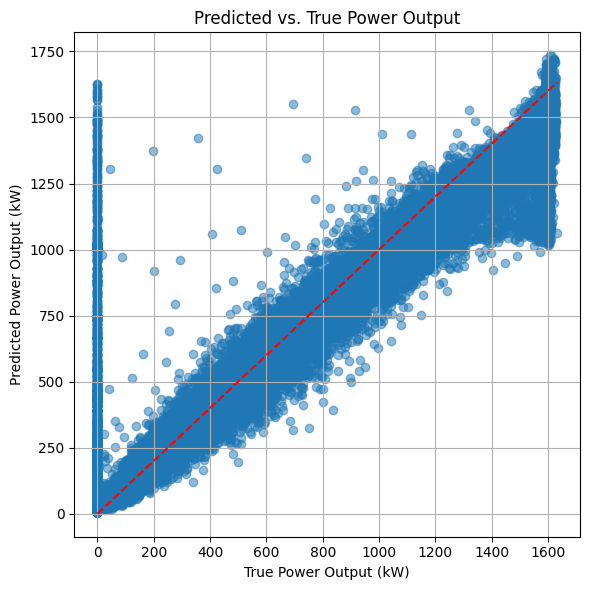

In [74]:
import numpy as np

y_true = np.array(y_true)
y_preds = np.array(y_preds)

plt.figure(figsize=(6, 6))
plt.scatter(y_true, y_preds, alpha=0.5)
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], '--', color='red')
plt.xlabel('True Power Output (kW)')
plt.ylabel('Predicted Power Output (kW)')
plt.title('Predicted vs. True Power Output')
plt.grid(True)
plt.tight_layout()
plt.show()


## ✅ ANN Evaluation Metrics

The ANN model was evaluated on the 10-minute interval test set. The results:

- **Mean Absolute Error (MAE)**: `78.20 kW`
- **Root Mean Squared Error (RMSE)**: `166.80 kW`
- **R² Score**: `0.8954`

---

### 📈 Interpretation

- **MAE** of 78.20 kW means the model's predictions are, on average, within ~78 kW of the true value.
- **RMSE** is higher due to some larger errors — especially on cases where turbines produce **zero output**, but the model predicts otherwise.
- **R²** of 0.8954 indicates that the model explains ~90% of the variability in turbine power output — a strong result for a feedforward ANN baseline.

---

### ⚠️ Room for Improvement

- The model **does not accurately capture "off" conditions**, where turbines should output 0 kW (e.g., very low wind).
- A future model might improve this by:
  - Adding a binary feature like `WindAboveCutIn`
  - Using a **two-stage model** (classification → regression)
  - Incorporating wind direction or power status

This ANN provides a strong starting point for comparison with future models like CNN, ViT, and GNN.


In [37]:

import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import torch.nn as nn

# --- Step 1: Create sliding windows
sequence_length = 12  # 2 hours
X_seq = []
y_seq = []

for i in range(len(X) - sequence_length):
    X_seq.append(X[i:i+sequence_length])      # shape: [12, 3, 5]
    y_seq.append(y[i + sequence_length])      # predict next timestep

X_seq = np.array(X_seq)                       # [samples, 12, 3, 5]
y_seq = np.array(y_seq)                       # [samples, 5]

# Flatten X: [samples, 12, 3, 5] → [samples, 180]
X_flat = X_seq.reshape(X_seq.shape[0], -1)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_flat, y_seq, test_size=0.2, random_state=42)

# Dataset
class TemporalANN(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_ds = TemporalANN(X_train, y_train)
test_ds = TemporalANN(X_test, y_test)
train_dl = DataLoader(train_ds, batch_size=64, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=64)

# --- Step 2: Define the ANN
class FC_ANN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim)
        )

    def forward(self, x):
        return self.model(x)

# Model init
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FC_ANN(input_dim=X_flat.shape[1], output_dim=5).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

# --- Step 3: Train
def train(model, loader, optimizer, loss_fn, epochs=20):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            pred = model(xb)
            loss = loss_fn(pred, yb)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}, Loss: {total_loss/len(loader):.2f}")

train(model, train_dl, optimizer, loss_fn)


Epoch 1, Loss: 122465.58
Epoch 2, Loss: 50058.62
Epoch 3, Loss: 40089.31
Epoch 4, Loss: 36108.65
Epoch 5, Loss: 34045.03
Epoch 6, Loss: 32420.81
Epoch 7, Loss: 31023.58
Epoch 8, Loss: 29635.97
Epoch 9, Loss: 28458.43
Epoch 10, Loss: 27520.61
Epoch 11, Loss: 26806.11
Epoch 12, Loss: 26025.92
Epoch 13, Loss: 25287.16
Epoch 14, Loss: 24778.70
Epoch 15, Loss: 24066.09
Epoch 16, Loss: 23454.37
Epoch 17, Loss: 23012.79
Epoch 18, Loss: 22562.22
Epoch 19, Loss: 22182.29
Epoch 20, Loss: 21857.29


In [38]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Evaluate
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for xb, yb in test_dl:
        xb = xb.to(device)
        preds = model(xb).cpu().numpy()
        yb = yb.numpy()
        y_pred.append(preds)
        y_true.append(yb)

y_true = np.vstack(y_true)
y_pred = np.vstack(y_pred)

# Per-turbine evaluation
turbines = ['T01', 'T02', 'T03', 'T04', 'T05']
print(f"{'Turbine':<6}  {'MAE (kW)':>10}  {'RMSE (kW)':>12}  {'R²':>8}")
print("-" * 40)
for i, turbine in enumerate(turbines):
    mae = mean_absolute_error(y_true[:, i], y_pred[:, i])
    rmse = np.sqrt(mean_squared_error(y_true[:, i], y_pred[:, i]))
    r2 = r2_score(y_true[:, i], y_pred[:, i])
    print(f"{turbine:<6}  {mae:10.2f}  {rmse:12.2f}  {r2:8.4f}")


Turbine    MAE (kW)     RMSE (kW)        R²
----------------------------------------
T01         101.69        165.47    0.8993
T02          91.64        144.26    0.9205
T03          92.24        150.49    0.9118
T04          98.93        158.85    0.9069
T05          95.02        152.03    0.9089


## 📊 Temporal ANN Evaluation Results (12 Timesteps @ 10-Min Intervals)

The fully connected temporal ANN was trained using the last **2 hours** (12×10-min) of wind data to predict the power output of each turbine at the next timestamp.

### 🔢 Performance Metrics (Per Turbine)

| Turbine | MAE (kW) | RMSE (kW) | R² Score |
|---------|----------|-----------|----------|
| **T01** | 101.69   | 165.47    | 0.8993   |
| **T02** | 91.64    | 144.26    | 0.9205   |
| **T03** | 92.24    | 150.49    | 0.9118   |
| **T04** | 98.93    | 158.85    | 0.9069   |
| **T05** | 95.02    | 152.03    | 0.9089   |

---

### ✅ Key Insights

- All **R² scores are above 0.89**, indicating the model explains **~90% of the variance** in turbine power output.
- **T02** shows the best performance (lowest MAE and highest R²) — suggesting it may have a more direct or stable relationship with wind conditions.
- **T01** and **T04** have slightly higher errors, which could reflect:
  - Wake interference
  - Shutdown behavior
  - Sensitivity to certain wind directions or speed transitions

---

### 🧠 Interpretability & Goal Alignment

These results confirm that:
- The ANN successfully captures general wind-to-power dynamics
- There is still room for improvement in understanding **why** some turbines (like T01) underperform in certain wind scenarios

---

### 🧭 Next Steps

We will now:
1. Generate **saliency maps** to see which wind inputs influenced each prediction
2. Visualize **wind direction vs power loss** to uncover shutdown or wake patterns
3. Optionally compare with a CNN-GRU or GNN for spatial-temporal modeling



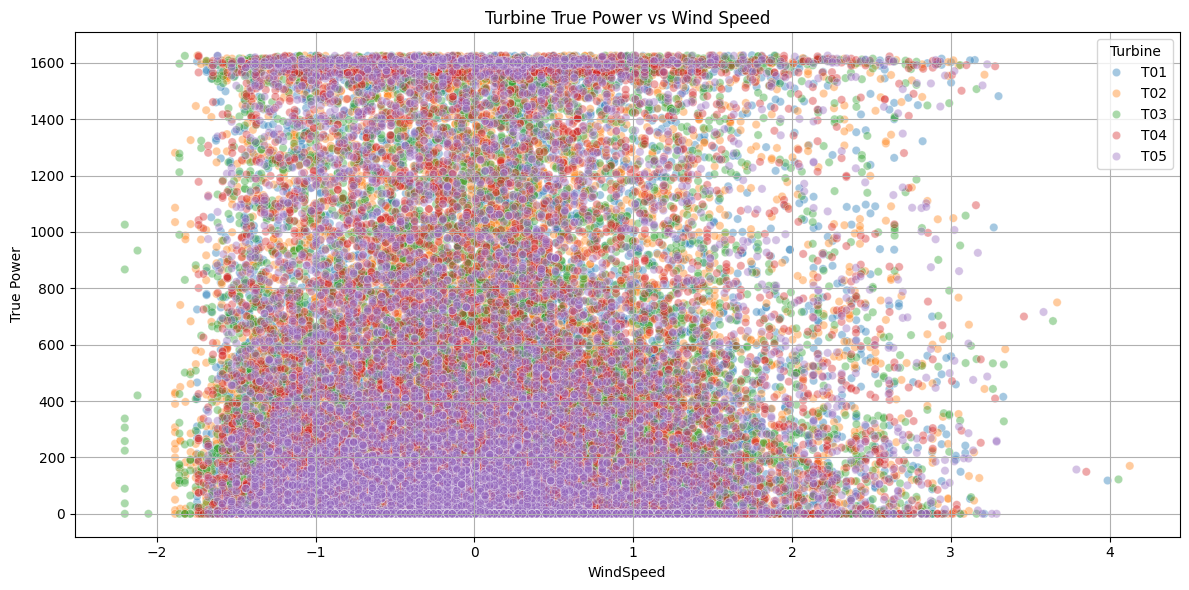

In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Create wide DataFrames with default indices
turbines = ['T01', 'T02', 'T03', 'T04', 'T05']
df_eval = pd.DataFrame(y_true, columns=[f'{t}_true' for t in turbines]).reset_index(drop=True)
df_pred = pd.DataFrame(y_pred, columns=[f'{t}_pred' for t in turbines]).reset_index(drop=True)

# Pull wind speed from the last time step of each sequence
last_wind_speeds = X_seq[-len(df_eval):, -1, 0, :]  # align length with y_true
df_wind = pd.DataFrame(last_wind_speeds, columns=[f'{t}_wind' for t in turbines]).reset_index(drop=True)

# Combine all
df_all = pd.concat([df_eval, df_pred, df_wind], axis=1)

# Melt to long format
melted = pd.DataFrame()
for t in turbines:
    temp = pd.DataFrame({
        'Turbine': t,
        'True Power': df_all[f'{t}_true'],
        'Predicted Power': df_all[f'{t}_pred'],
        'WindSpeed': df_all[f'{t}_wind']
    })
    melted = pd.concat([melted, temp], axis=0, ignore_index=True)

# Plot: True power vs wind speed per turbine
plt.figure(figsize=(12, 6))
sns.scatterplot(data=melted, x='WindSpeed', y='True Power', hue='Turbine', alpha=0.4)
plt.title('Turbine True Power vs Wind Speed')
plt.grid(True)
plt.tight_layout()
plt.show()


In [43]:
scaler.mean_[wind_speed_index]

0.12255045104635832

/tmp/ipykernel_58679/31098963.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = power.groupby(binned).median()
/tmp/ipykernel_58679/31098963.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = power.groupby(binned).median()
/tmp/ipykernel_58679/31098963.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = power.groupby(binned).median()
/tmp/ipykernel_58679/31098963.py:22: FutureWarning: 

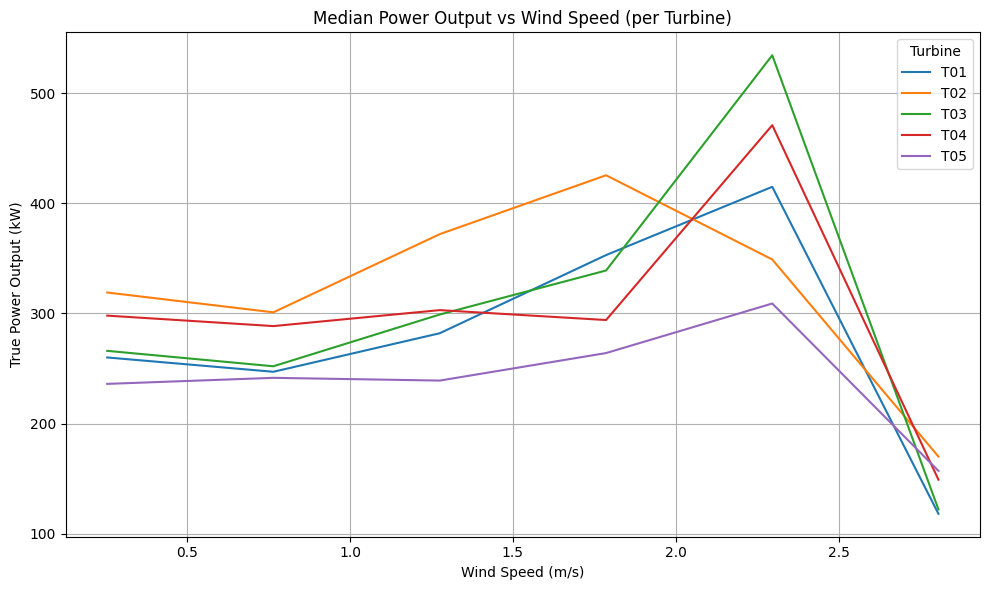

In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- STEP 1: Get original wind speed stats
wind_speed_index = 0  # WindSpeed is the first feature
wind_mean = scaler.mean_[wind_speed_index]
wind_std = np.sqrt(scaler.var_[wind_speed_index])  # std is sqrt of var

# --- STEP 2: Inverse-transform wind speed to m/s
for t in turbines:
    df_all[f'{t}_wind'] = df_all[f'{t}_wind'] * wind_std + wind_mean

# --- STEP 3: Bin wind speeds and calculate median true power
bins = np.linspace(0, 25, 50)  # Wind speed from 0 to 25 m/s
binned_stats = pd.DataFrame()

for t in turbines:
    wind = df_all[f'{t}_wind']
    power = df_all[f'{t}_true']
    binned = pd.cut(wind, bins)
    grouped = power.groupby(binned).median()
    binned_stats[t] = grouped.values

binned_stats['WindSpeed (m/s)'] = [interval.mid for interval in grouped.index]

# --- STEP 4: Plot clean power curves
plt.figure(figsize=(10, 6))
for t in turbines:
    plt.plot(binned_stats['WindSpeed (m/s)'], binned_stats[t], label=t)

plt.title('Median Power Output vs Wind Speed (per Turbine)')
plt.xlabel('Wind Speed (m/s)')
plt.ylabel('True Power Output (kW)')
plt.legend(title="Turbine")
plt.grid(True)
plt.tight_layout()
plt.show()


/tmp/ipykernel_58679/392120847.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  agg = df_long.groupby(['Turbine', 'WindBin'])['Power'].median().reset_index()


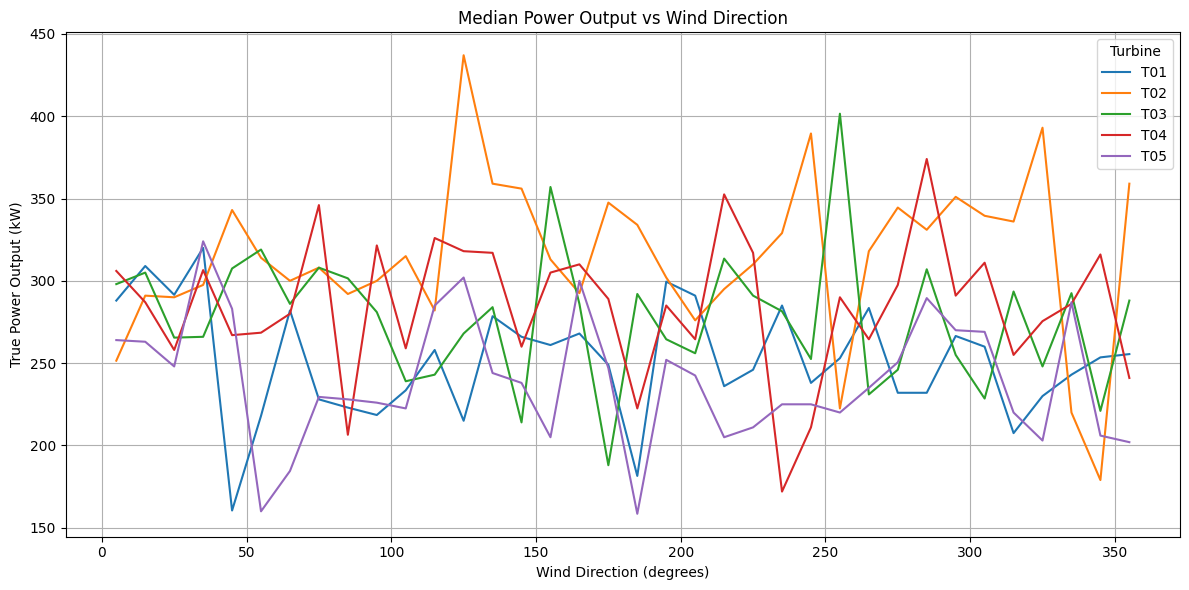

In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# STEP 1: Extract u and v (unit vectors) from last timestep of each sample
u_last = X_seq[-len(df_all):, -1, 1, :]  # u = cos(theta)
v_last = X_seq[-len(df_all):, -1, 2, :]  # v = sin(theta)

# STEP 2: Calculate wind direction (0–360 degrees)
wind_dir_deg = (np.degrees(np.arctan2(-u_last, -v_last)) + 360) % 360  # shape: [samples, turbines]

# STEP 3: Create long-format DataFrame for plotting
df_dir = pd.DataFrame(wind_dir_deg, columns=[f'{t}_dir' for t in turbines])
df_long = pd.DataFrame()

for t in turbines:
    temp = pd.DataFrame({
        'Turbine': t,
        'WindDir': df_dir[f'{t}_dir'],
        'Power': df_all[f'{t}_true']
    })
    df_long = pd.concat([df_long, temp], axis=0, ignore_index=True)

# STEP 4: Bin directions into 10° intervals and compute median power
df_long['WindBin'] = pd.cut(df_long['WindDir'], bins=np.arange(0, 361, 10))
agg = df_long.groupby(['Turbine', 'WindBin'])['Power'].median().reset_index()
agg['WindMid'] = agg['WindBin'].apply(lambda x: x.mid)

# STEP 5: Plot per-turbine power vs wind direction
plt.figure(figsize=(12, 6))
for t in turbines:
    subset = agg[agg['Turbine'] == t]
    plt.plot(subset['WindMid'], subset['Power'], label=t)

plt.title('Median Power Output vs Wind Direction')
plt.xlabel('Wind Direction (degrees)')
plt.ylabel('True Power Output (kW)')
plt.grid(True)
plt.legend(title='Turbine')
plt.tight_layout()
plt.show()


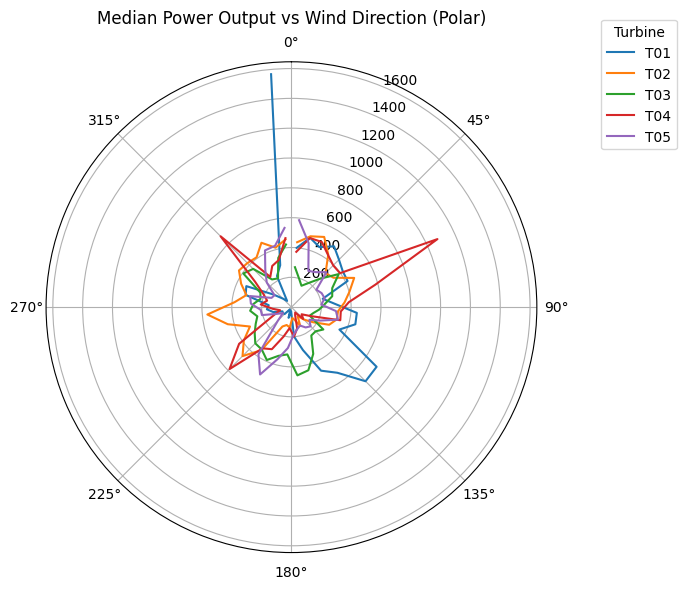

In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- STEP 1: Prepare input data from your original dataframe
# Assumes df has: 'Turbine', 'WindDirection', 'PowerkW'
df_plot = df[['Turbine', 'WindDirection', 'PowerkW']].copy()
df_plot = df_plot[df_plot['WindDirection'].notna()]  # Drop any nulls

# --- STEP 2: Bin wind directions (every 10°)
df_plot['WindBin'] = pd.cut(df_plot['WindDirection'], bins=np.arange(0, 370, 10))
df_plot['WindMid'] = df_plot['WindBin'].apply(lambda x: x.mid)

# --- STEP 3: Group by turbine and wind bin, compute median power
agg = df_plot.groupby(['Turbine', 'WindMid'], observed=True)['PowerkW'].median().reset_index()

# --- STEP 4: Convert degrees to radians for polar plotting
agg['WindRad'] = np.deg2rad(agg['WindMid'].astype(float))

# --- STEP 5: Create the polar plot
plt.figure(figsize=(8, 6))
ax = plt.subplot(111, polar=True)

for t in agg['Turbine'].unique():
    df_t = agg[agg['Turbine'] == t]
    ax.plot(df_t['WindRad'], df_t['PowerkW'], label=t)

# --- STEP 6: Format the plot
ax.set_theta_zero_location('N')     # 0° at top (North)
ax.set_theta_direction(-1)          # Clockwise direction
ax.set_title('Median Power Output vs Wind Direction (Polar)', va='bottom')
ax.legend(title='Turbine', loc='upper right', bbox_to_anchor=(1.3, 1.1))
plt.tight_layout()
plt.show()


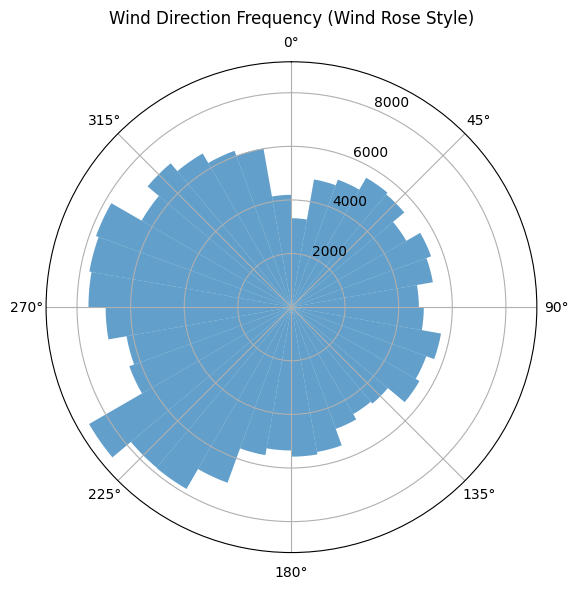

In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- STEP 1: Bin wind direction from 0° to 360° in 10° increments
wind_bins = np.arange(0, 370, 10)
df['WindBin'] = pd.cut(df['WindDirection'], bins=wind_bins, right=False)
df['WindMid'] = df['WindBin'].apply(lambda x: x.mid)

# --- STEP 2: Count how often each direction appears
wind_freq = df['WindMid'].value_counts().sort_index()

# --- STEP 3: Convert to radians for polar plotting
wind_angles = np.deg2rad(wind_freq.index.astype(float))

# --- STEP 4: Polar bar chart
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, polar=True)

bars = ax.bar(wind_angles, wind_freq.values, width=np.deg2rad(10), bottom=0.0, alpha=0.7)

ax.set_theta_zero_location('N')  # North at top
ax.set_theta_direction(-1)       # Clockwise
ax.set_title("Wind Direction Frequency (Wind Rose Style)", va='bottom')

plt.tight_layout()
plt.show()


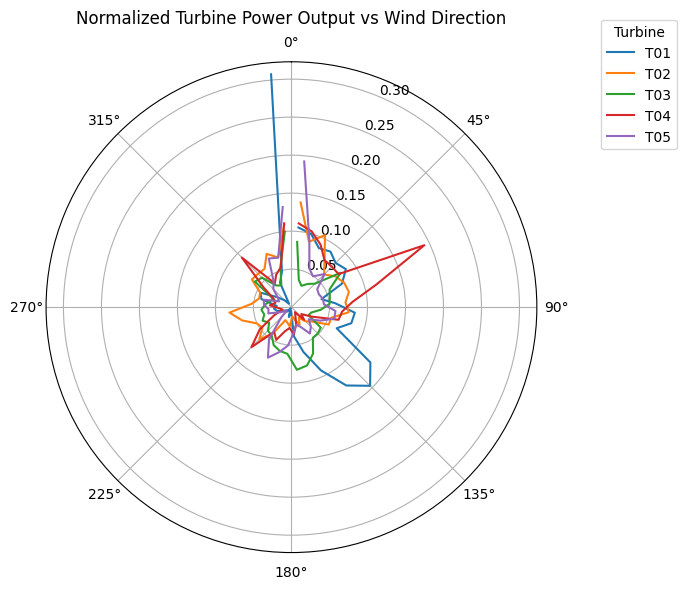

In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- STEP 1: Bin directions
df['WindBin'] = pd.cut(df['WindDirection'], bins=np.arange(0, 370, 10), right=False)
df['WindMid'] = df['WindBin'].apply(lambda x: x.mid).astype(float)  # convert to float

# --- STEP 2: Frequency of each direction
wind_freq = df['WindMid'].value_counts().sort_index()

# --- STEP 3: Median power output per turbine and direction
agg = df.groupby(['Turbine', 'WindMid'], observed=True)['PowerkW'].median().reset_index()

# --- STEP 4: Normalize by wind frequency
agg['WindFreq'] = agg['WindMid'].map(wind_freq)
agg['NormalizedPower'] = agg['PowerkW'] / agg['WindFreq']

# --- STEP 5: Convert direction to radians
agg['WindRad'] = np.deg2rad(agg['WindMid'])

# --- STEP 6: Plot polar chart
plt.figure(figsize=(8, 6))
ax = plt.subplot(111, polar=True)

for t in agg['Turbine'].unique():
    df_t = agg[agg['Turbine'] == t]
    ax.plot(df_t['WindRad'], df_t['NormalizedPower'], label=t)

ax.set_theta_zero_location('N')
ax.set_theta_direction(-1)
ax.set_title("Normalized Turbine Power Output vs Wind Direction", va='bottom')
ax.legend(title='Turbine', bbox_to_anchor=(1.3, 1.1))

plt.tight_layout()
plt.show()


# CNN

In [78]:
from sklearn.preprocessing import StandardScaler

# Standardize features per feature group (across turbines)
scaled_features = []
scalers = {}
for feature in features:
    scaler = StandardScaler()
    values = feature_tensor[feature].values
    scaled = scaler.fit_transform(values)
    scaled_features.append(scaled)
    scalers[feature] = scaler


In [79]:
X = np.stack(scaled_features, axis=1)  # shape: [samples, 3, 5]
y = target_tensor.values               # shape: [samples, 5]

In [23]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader

# === Replace this with your actual DataFrame ===
# df = pd.read_csv("your_data.csv")
# Columns: ['Turbine', 'StampTime', 'WindSpeed', 'u_vector', 'v_vector', 'PowerkW']

# === Pivot and format ===
features = ['WindSpeed', 'u_vector', 'v_vector']
target = 'PowerkW'

# Pivot so each row is a full snapshot of all turbines at one timestamp
feature_tensor = df.pivot(index='StampTime', columns='Turbine', values=features)
target_tensor = df.pivot(index='StampTime', columns='Turbine', values=target)

# === Standardize features ===
scaled_features = []
scalers = {}

for feature in features:
    scaler = StandardScaler()
    scaled = scaler.fit_transform(feature_tensor[feature])
    scaled_features.append(scaled)
    scalers[feature] = scaler

# Stack into [samples, channels, turbines]
X = np.stack(scaled_features, axis=1)  # shape: [n_samples, 3, 5]
y = target_tensor.values               # shape: [n_samples, 5]

# === Train/test split ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# === Dataset class ===
class CNNTurbineDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_ds = CNNTurbineDataset(X_train, y_train)
test_ds = CNNTurbineDataset(X_test, y_test)

train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=32)

# Output to confirm
print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)


Train shape: (34640, 3, 5)
Test shape: (8661, 3, 5)


In [25]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset

# === CNN Model ===
class TurbineCNN(nn.Module):
    def __init__(self, in_channels, out_turbines):
        super(TurbineCNN, self).__init__()
        self.net = nn.Sequential(
            nn.Conv1d(in_channels, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv1d(32, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(16 * out_turbines, 64),
            nn.ReLU(),
            nn.Linear(64, out_turbines)
        )

    def forward(self, x):
        return self.net(x)

# === Device ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# === Dataset & Dataloader ===
class CNNTurbineDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_ds = CNNTurbineDataset(X_train, y_train)
test_ds = CNNTurbineDataset(X_test, y_test)
train_dl = DataLoader(train_ds, batch_size=64, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=64)

# === Initialize model ===
model = TurbineCNN(in_channels=3, out_turbines=5).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

# === Training Loop ===
def train(model, loader, optimizer, loss_fn, epochs=20):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            pred = model(xb)
            loss = loss_fn(pred, yb)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss / len(loader):.4f}")

# === Train ===
train(model, train_dl, optimizer, loss_fn)


Using device: cuda
Epoch 1/20, Loss: 139353.7072
Epoch 2/20, Loss: 54028.7471
Epoch 3/20, Loss: 43264.8815
Epoch 4/20, Loss: 36478.0714
Epoch 5/20, Loss: 31212.6463
Epoch 6/20, Loss: 26378.6648
Epoch 7/20, Loss: 22726.7583
Epoch 8/20, Loss: 20381.2856
Epoch 9/20, Loss: 18567.4257
Epoch 10/20, Loss: 16825.5160
Epoch 11/20, Loss: 15098.8176
Epoch 12/20, Loss: 14045.9592
Epoch 13/20, Loss: 13392.8650
Epoch 14/20, Loss: 12767.8241
Epoch 15/20, Loss: 12115.1894
Epoch 16/20, Loss: 11475.6208
Epoch 17/20, Loss: 11012.2792
Epoch 18/20, Loss: 10657.0218
Epoch 19/20, Loss: 10346.5632
Epoch 20/20, Loss: 10090.6807



📊 CNN Model Performance on Test Set:
MAE:  49.79 kW
RMSE: 104.15 kW
R²:   0.9598


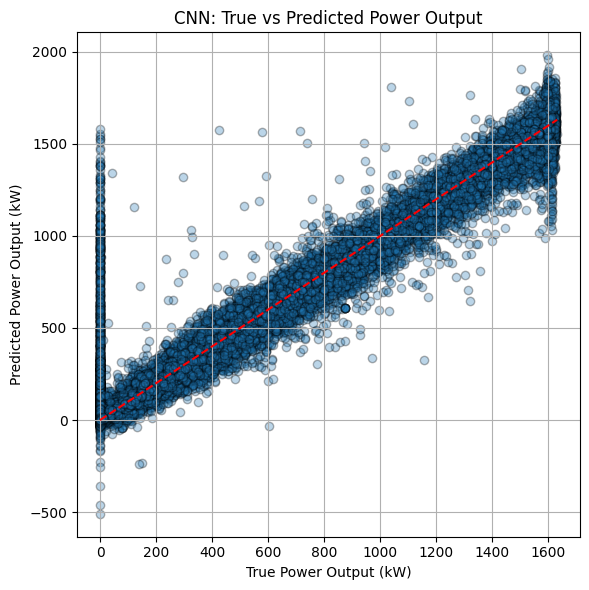

In [26]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

# === Evaluation ===
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for xb, yb in test_dl:
        xb = xb.to(device)
        preds = model(xb).cpu().numpy()
        yb = yb.cpu().numpy()
        y_pred.append(preds)
        y_true.append(yb)

# Convert lists to arrays
y_true = np.vstack(y_true)  # shape: [samples, turbines]
y_pred = np.vstack(y_pred)

# === Calculate Metrics ===
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2 = r2_score(y_true, y_pred)

print(f"\n📊 CNN Model Performance on Test Set:")
print(f"MAE:  {mae:.2f} kW")
print(f"RMSE: {rmse:.2f} kW")
print(f"R²:   {r2:.4f}")

# === Plot: True vs Predicted ===
plt.figure(figsize=(6, 6))
plt.scatter(y_true.flatten(), y_pred.flatten(), alpha=0.3, edgecolor='k')
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
plt.xlabel('True Power Output (kW)')
plt.ylabel('Predicted Power Output (kW)')
plt.title('CNN: True vs Predicted Power Output')
plt.grid(True)
plt.tight_layout()
plt.show()


In [27]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

turbines = ['T01', 'T02', 'T03', 'T04', 'T05']  # adjust if needed
print("\n📍 Per-Turbine Metrics:")
print(f"{'Turbine':<6}  {'MAE (kW)':>10}  {'RMSE (kW)':>12}  {'R²':>8}")
print("-" * 40)

for i, turbine in enumerate(turbines):
    y_t = y_true[:, i]
    y_p = y_pred[:, i]
    
    mae = mean_absolute_error(y_t, y_p)
    rmse = np.sqrt(mean_squared_error(y_t, y_p))
    r2 = r2_score(y_t, y_p)
    
    print(f"{turbine:<6}  {mae:10.2f}  {rmse:12.2f}  {r2:8.4f}")



📍 Per-Turbine Metrics:
Turbine    MAE (kW)     RMSE (kW)        R²
----------------------------------------
T01          68.55        132.28    0.9368
T02          41.70         82.50    0.9747
T03          45.86         98.72    0.9627
T04          47.30        103.82    0.9611
T05          45.54         96.98    0.9637


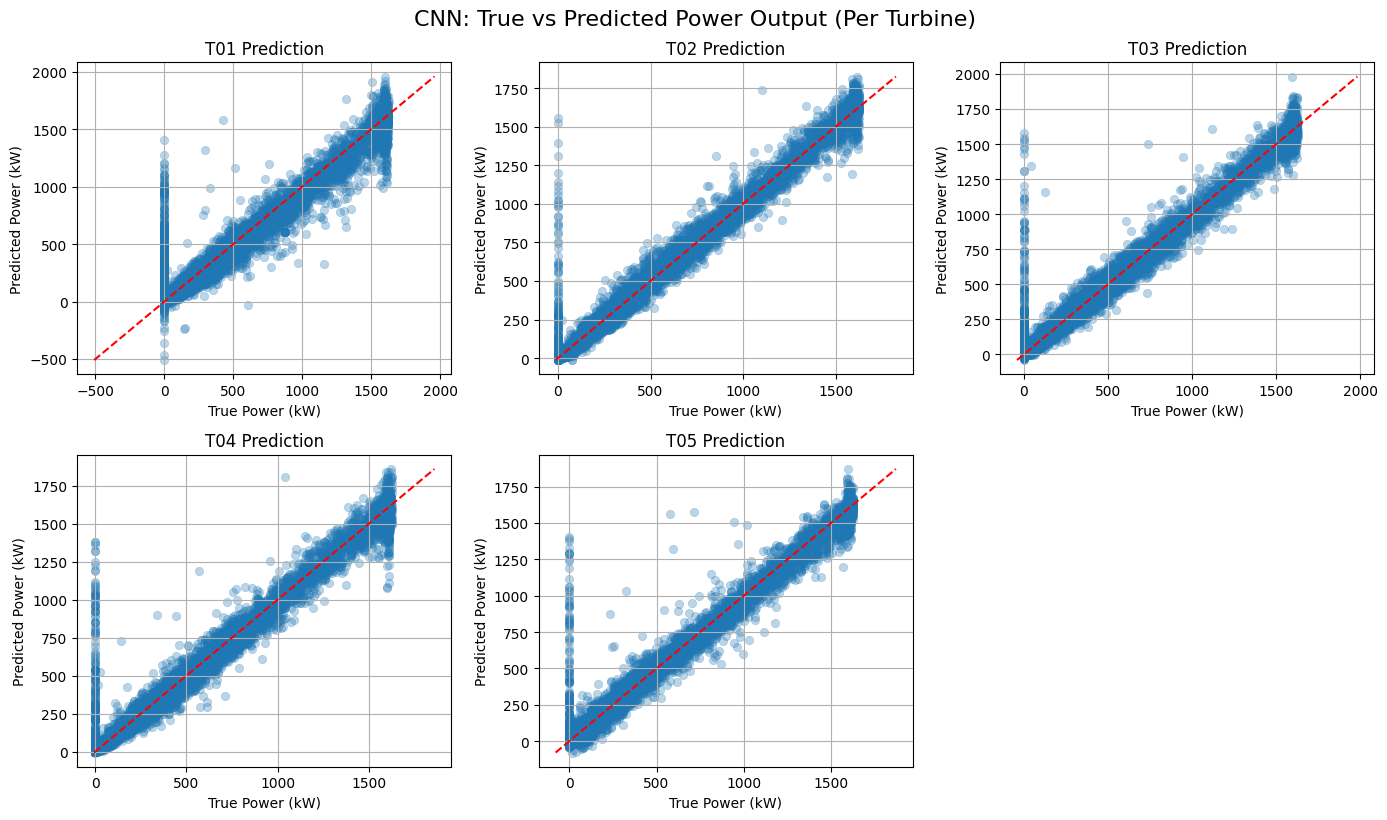

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Make sure these arrays are available
# y_true: [n_samples, 5]
# y_pred: [n_samples, 5]
turbines = ['T01', 'T02', 'T03', 'T04', 'T05']

plt.figure(figsize=(14, 8))
for i, turbine in enumerate(turbines):
    plt.subplot(2, 3, i + 1)
    sns.scatterplot(x=y_true[:, i], y=y_pred[:, i], alpha=0.3, edgecolor=None)
    min_val = min(y_true[:, i].min(), y_pred[:, i].min())
    max_val = max(y_true[:, i].max(), y_pred[:, i].max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=1.5)
    plt.xlabel('True Power (kW)')
    plt.ylabel('Predicted Power (kW)')
    plt.title(f'{turbine} Prediction')
    plt.grid(True)

plt.tight_layout()
plt.suptitle('CNN: True vs Predicted Power Output (Per Turbine)', fontsize=16, y=1.02)
plt.show()


In [36]:
# df

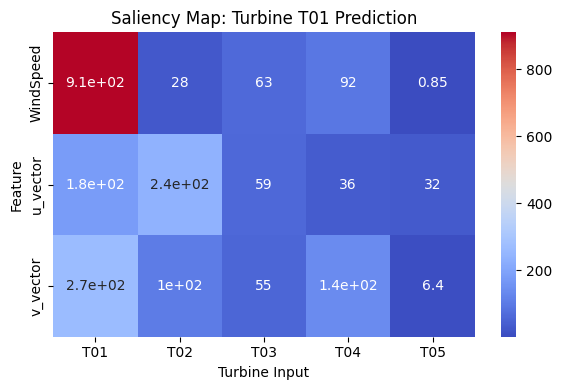

In [31]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Pick a sample from test set
sample_idx = 0
sample_input_np = X_test[sample_idx:sample_idx+1]  # shape: [1, 3, 5]

# Convert to tensor and retain gradient
sample_input_tensor = torch.tensor(sample_input_np, dtype=torch.float32, requires_grad=True).to(device)
sample_input_tensor.retain_grad()  # ✅ this is what fixes it

# Forward pass
model.eval()
output = model(sample_input_tensor)

# Pick turbine to explain (e.g., T01)
turbine_index = 0
target_output = output[0, turbine_index]

# Backward pass to compute gradients
model.zero_grad()
target_output.backward()

# Extract saliency map (abs of gradient)
saliency = sample_input_tensor.grad.abs().squeeze().cpu().numpy()  # shape: [3, 5]

# Plot saliency as heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(saliency, annot=True, cmap='coolwarm', xticklabels=turbines, yticklabels=['WindSpeed', 'u_vector', 'v_vector'])
plt.title(f'Saliency Map: Turbine {turbines[turbine_index]} Prediction')
plt.xlabel('Turbine Input')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


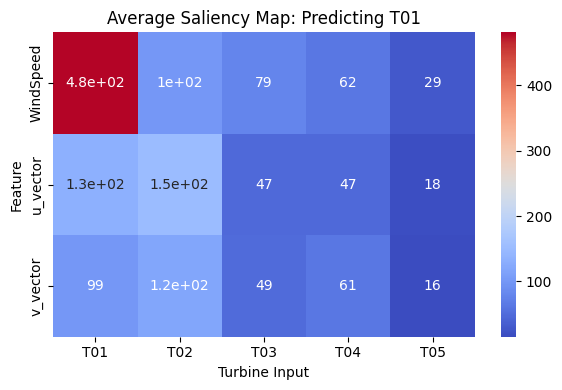

In [33]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set parameters
target_turbine_idx = 0  # T01
num_samples = 1000  # how many test samples to analyze

# Store saliency maps
saliency_maps = []

model.eval()

for i in range(num_samples):
    sample = X_test[i:i+1]
    input_tensor = torch.tensor(sample, dtype=torch.float32, requires_grad=True).to(device)
    input_tensor.retain_grad()

    output = model(input_tensor)
    output[0, target_turbine_idx].backward()
    
    # Get saliency (abs gradients)
    grad = input_tensor.grad.abs().squeeze().cpu().numpy()  # [3, 5]
    saliency_maps.append(grad)

# Compute mean saliency map
mean_saliency = np.mean(saliency_maps, axis=0)  # shape: [3, 5]

# Plot average saliency
plt.figure(figsize=(6, 4))
sns.heatmap(mean_saliency, annot=True, cmap='coolwarm',
            xticklabels=turbines, yticklabels=['WindSpeed', 'u_vector', 'v_vector'])
plt.title(f'Average Saliency Map: Predicting {turbines[target_turbine_idx]}')
plt.xlabel('Turbine Input')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()
